Saving DA -Task 2..xlsx to DA -Task 2. (6).xlsx


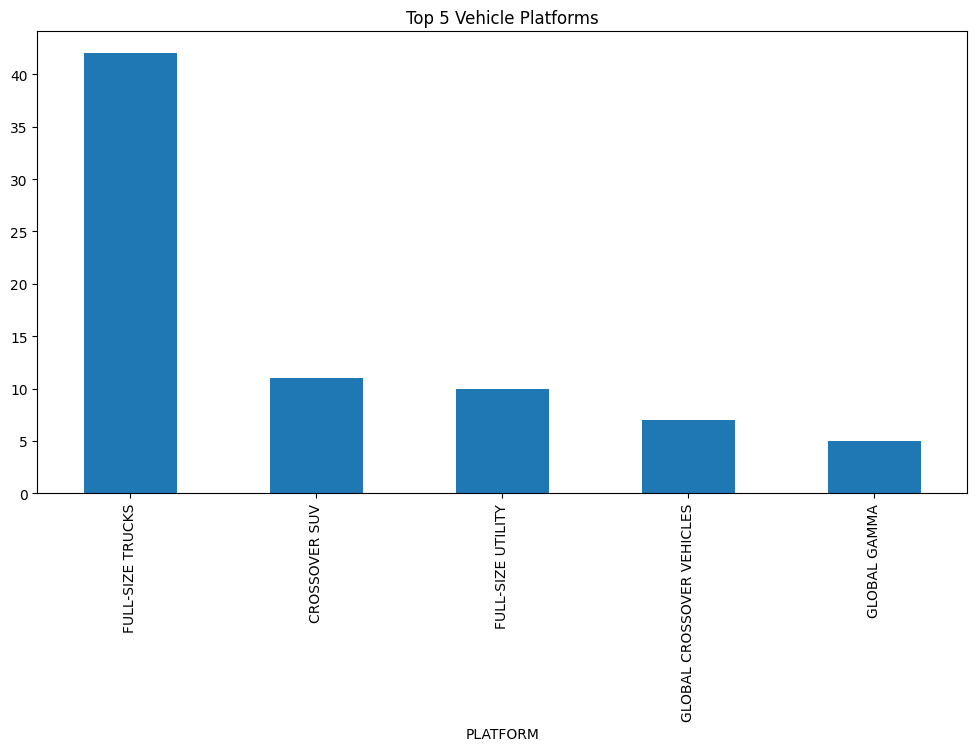

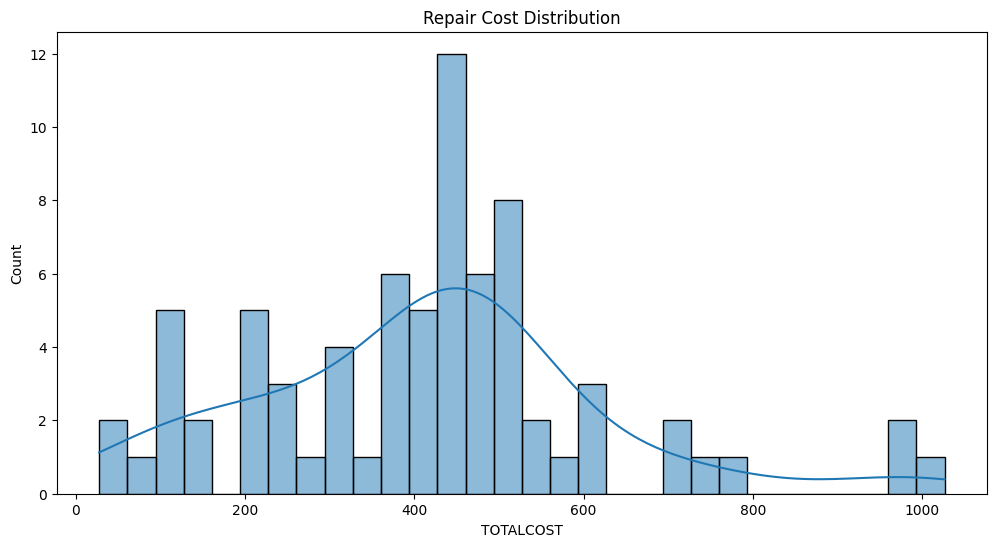

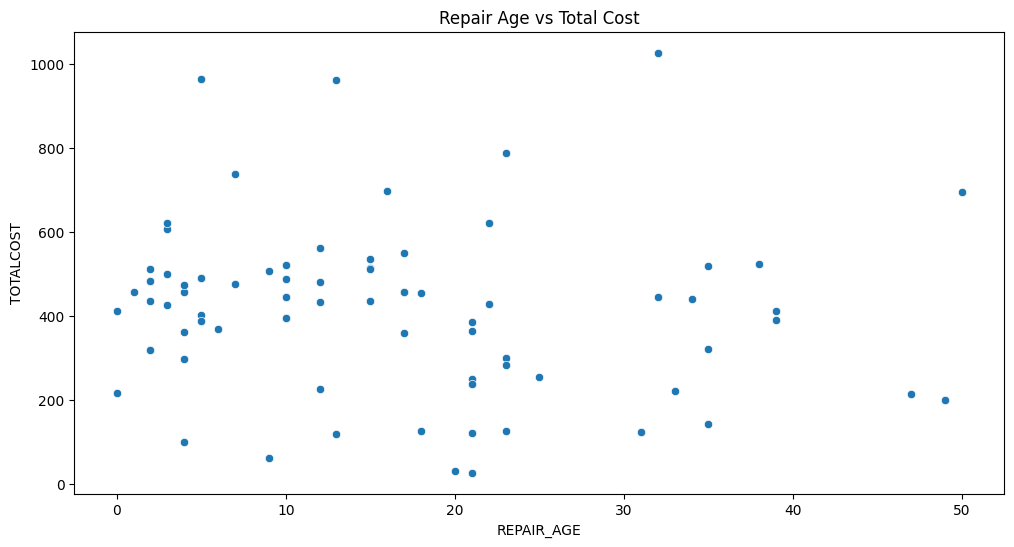

In [9]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# Step 1: Upload & Load Dataset
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_excel(file_name)

# Step 2: Column-wise Analysis (logged to text)
def column_summary(df):
    summary = []
    for col in df.columns:
        dtype = df[col].dtype
        unique = df[col].nunique()
        missing = df[col].isnull().sum()
        examples = df[col].dropna().unique()[:3]
        summary.append(f"{col} | Type: {dtype} | Unique: {unique} | Missing: {missing} | Examples: {examples}")
    return summary

# Save column analysis to a file
with open("column_analysis.txt", "w") as f:
    for line in column_summary(df):
        f.write(line + "\n")

df['CAUSAL_PART_NM'] = df['CAUSAL_PART_NM'].fillna('Unknown')
df['REPAIR_AGE'] = df['REPAIR_AGE'].fillna(df['REPAIR_AGE'].median())
df['KM'] = df['KM'].fillna(df['KM'].median())

# Categorical columns clean karein
df['PLATFORM'] = df['PLATFORM'].str.strip().str.upper()
df['BODY_STYLE'] = df['BODY_STYLE'].str.strip().str.title()

# Numeric columns fix karein
df['TOTALCOST'] = pd.to_numeric(df['TOTALCOST'], errors='coerce')
df['LBRCOST'] = pd.to_numeric(df['LBRCOST'], errors='coerce')

# Outliers remove karein (IQR method)
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR)))]

df = remove_outliers(df, 'TOTALCOST')
df = remove_outliers(df, 'LBRCOST')


# 5. Visualizations (Task 2 Requirement)
# 1. Top Platforms with Steering Issues
plt.figure(figsize=(12,6))
df['PLATFORM'].value_counts().head(5).plot(kind='bar')
plt.title('Top 5 Vehicle Platforms')
plt.savefig('platform_issues.png')
plt.show()

# 2. Repair Cost Distribution
plt.figure(figsize=(12,6))
sns.histplot(df['TOTALCOST'], bins=30, kde=True)
plt.title('Repair Cost Distribution')
plt.savefig('repair_cost_dist.png')
plt.show()

# 3. Repair Age vs. Cost
plt.figure(figsize=(12,6))
sns.scatterplot(x='REPAIR_AGE', y='TOTALCOST', data=df)
plt.title('Repair Age vs Total Cost')
plt.savefig('age_vs_cost.png')
plt.show()


# 6. Tag Generation (Task 2 Requirement)
# Failure Tags (Customer Complaints)
def extract_failure_tags(text):
    text = str(text).lower()
    tags = []
    if any(word in text for word in ['peel', 'coming apart', 'stitch']):
        tags.append('material_failure')
    if any(word in text for word in ['heat', 'warm', 'temperature']):
        tags.append('heating_issue')
    if any(word in text for word in ['horn', 'switch', 'button']):
        tags.append('electrical_issue')
    return ', '.join(tags) if tags else 'other_issue'

# Repair Tags (Technician Notes)
def extract_repair_tags(text):
    text = str(text).lower()
    tags = []
    if 'replace' in text:
        tags.append('replacement')
    if 'adjust' in text:
        tags.append('adjustment')
    if 'program' in text or 'software' in text:
        tags.append('software_fix')
    return ', '.join(tags) if tags else 'other_repair'

# Apply Tags
df['FAILURE_TAGS'] = df['CUSTOMER_VERBATIM'].apply(extract_failure_tags)
df['REPAIR_TAGS'] = df['CORRECTION_VERBATIM'].apply(extract_repair_tags)


# 7. Save Outputs (Task 2 Requirement)
# Cleaned & Tagged Data
df.to_csv('cleaned_tagged_steering_data.csv', index=False)

# Analysis Summary Report
report = f"""
Steering Wheel Repair Analysis Report

1. Top Platforms with Issues: {df['PLATFORM'].value_counts().idxmax()}
2. Most Common Failure: {df['FAILURE_TAGS'].value_counts().idxmax()}
3. Average Repair Cost: ${df['TOTALCOST'].mean():.2f}
4. Critical Observations:
   - Material failures (stitching/peeling) are frequent.
   - High costs observed in BEV/Luxury platforms.
"""

with open("analysis_summary.txt", "w") as f:
    f.write(report)

# 8. Download Outputs
# Download all files
files.download("column_analysis.txt")
files.download("cleaned_tagged_steering_data.csv")
files.download("top_platforms.png")
files.download("repair_cost_distribution.png")
files.download("age_vs_cost.png")
files.download("analysis_summary.txt")